In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## 1. Data Load
- 편의상 EDA와 전처리 진행 후 train, test 로 분리하였습니다

In [69]:
df = pd.read_csv("BankChurners.csv")
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### Dataset Columns Description

- CLIENTNUM  : ID
- **Attrition_Flag** : target attribute  
- Customer_Age : 나이
- Gender : 성별
- Dependent_count : 부양하는 가족의 수
- Education_Level : 학력
- Marital_Status : 결혼 여부
- Income_Category : 소득 수준 (범주형)
- Card_Category : 카드 등급  
- Months_on_book : 은행과의 거래 지속 기간 
- Total_Relationship_Count : 고객이 보유한 상품의 수
- Months_Inactive_12_mon : 지난 1년동안 비활성화 상태였던 개월 수 
- Contacts_Count_12_mon : 지난 1년동안 연락/거래 횟수
- Credit_Limit : 신용카드 한도
- Total_Revolving_Bal : 리볼빙 금액
- Avg_Open_To_Buy : 카드의 신용 한도와 현재 잔액 간 차이
- Total_Amt_Chng_Q4_Q1 : Q1 대비 Q4 거래 금액 변동률
- Total_Trans_Amt : 1년간 총 거래 금액
- Total_Trans_Ct : 1년간 총 거래 횟수
- Total_Ct_Chng_Q4_Q1 : Q1 대비 Q4 거래 횟수 변동률
- Avg_Utilization_Ratio : 신용카드 한도액 대비 사용 금액 비율 (신용카드 한도액의 30%를 넘지 않도록 사용을 하는 것을 권장 -> 신용점수와 연관)
- Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1    
- Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2

### 1.1 EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [6]:
df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [10]:
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
for col in cat_cols :
    if len(df[col].unique()) > 30 :
        continue
    else :
        print(f"{col} : {df[col].unique()}")

Attrition_Flag : ['Existing Customer' 'Attrited Customer']
Gender : ['M' 'F']
Education_Level : ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status : ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category : ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category : ['Blue' 'Gold' 'Silver' 'Platinum']


In [24]:
for col in df.columns :
    print(f"{col} : {df[col].nunique()}")

CLIENTNUM : 10127
Attrition_Flag : 2
Customer_Age : 45
Gender : 2
Dependent_count : 6
Education_Level : 7
Marital_Status : 4
Income_Category : 6
Card_Category : 4
Months_on_book : 44
Total_Relationship_Count : 6
Months_Inactive_12_mon : 7
Contacts_Count_12_mon : 7
Credit_Limit : 6205
Total_Revolving_Bal : 1974
Avg_Open_To_Buy : 6813
Total_Amt_Chng_Q4_Q1 : 1158
Total_Trans_Amt : 5033
Total_Trans_Ct : 126
Total_Ct_Chng_Q4_Q1 : 830
Avg_Utilization_Ratio : 964
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 : 1704
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2 : 640


In [25]:
df[df.duplicated()]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2


In [60]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

### 1.2 Preprocessing

In [70]:
# 불필요한 컬럼 제거 
df = df.iloc[:, :-2] # 
df.drop('CLIENTNUM', axis=1, inplace = True)

In [71]:
def numeric_iqr (df, col) :
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outliers.sum()

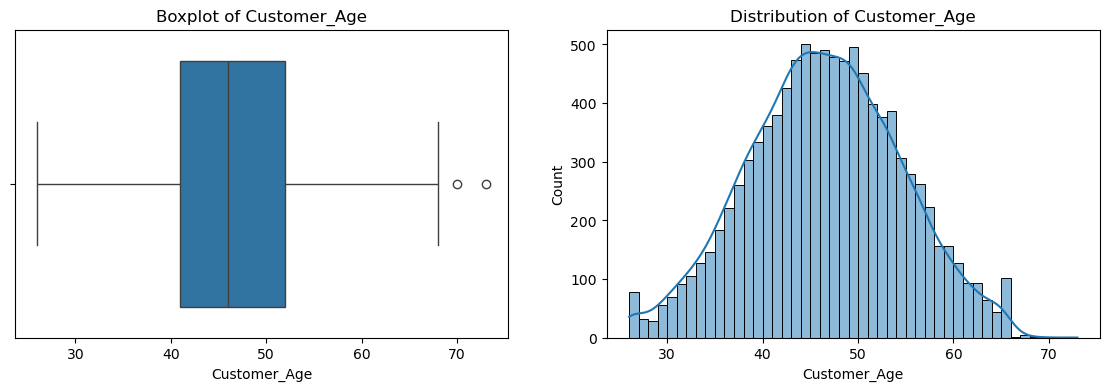

Num of outliers : 2
% of outliers : 0.019749185346104474 %


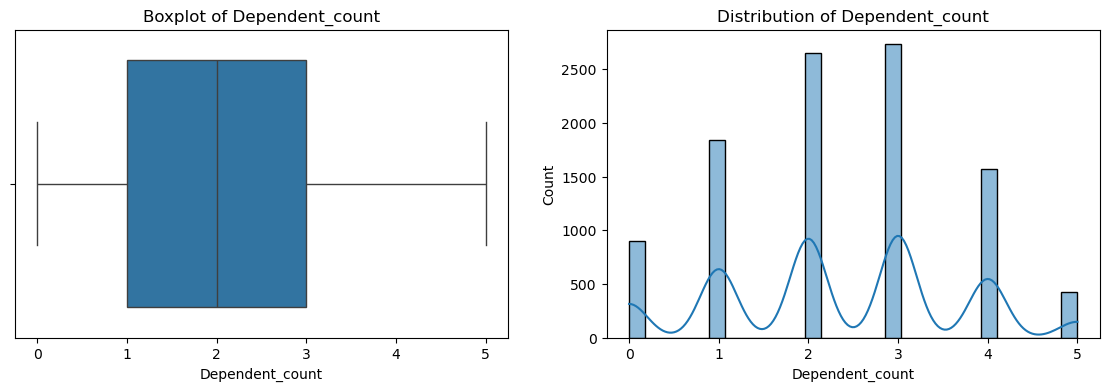

Num of outliers : 0
% of outliers : 0.0 %


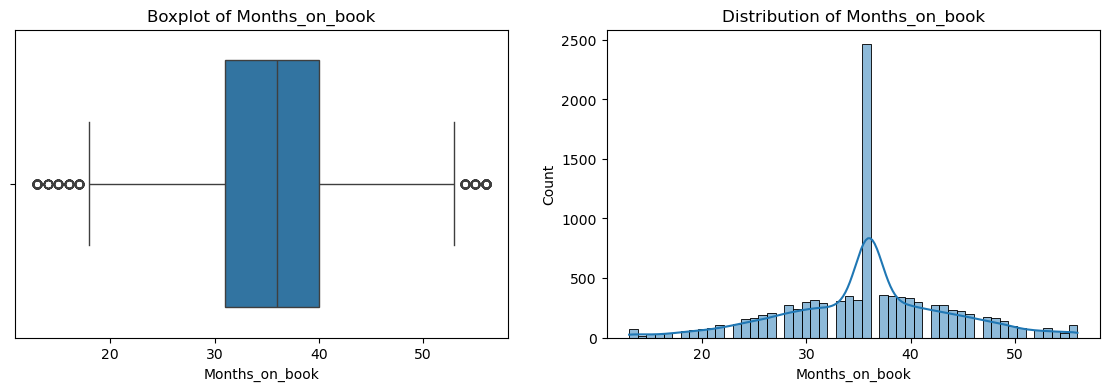

Num of outliers : 386
% of outliers : 3.8115927717981632 %


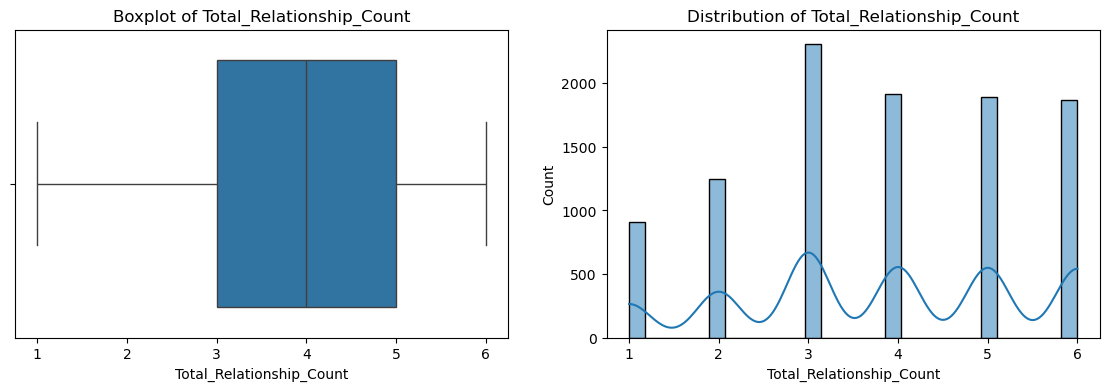

Num of outliers : 0
% of outliers : 0.0 %


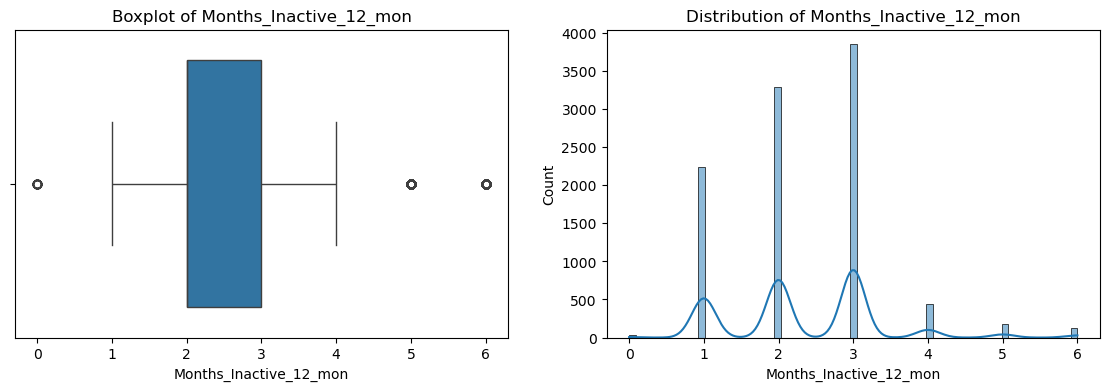

Num of outliers : 331
% of outliers : 3.2684901747802906 %


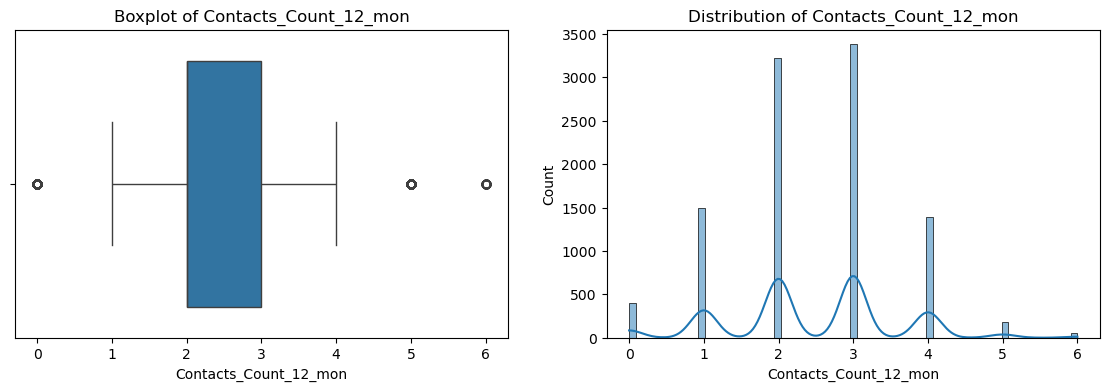

Num of outliers : 629
% of outliers : 6.211118791349857 %


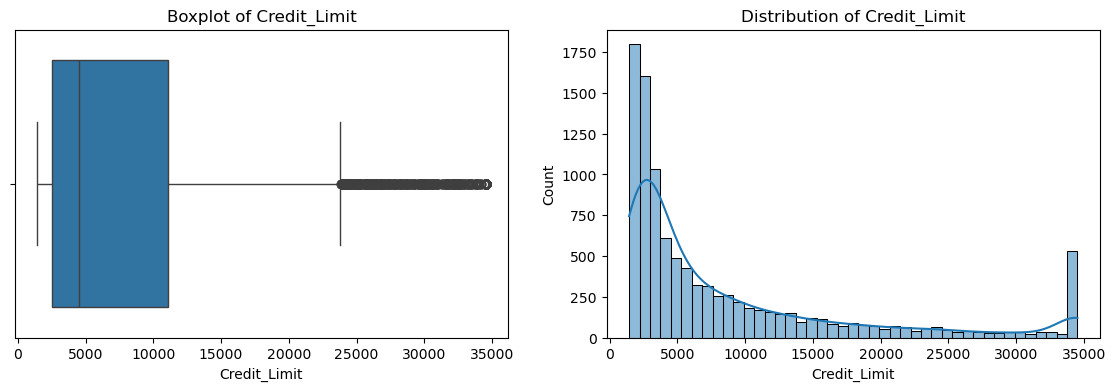

Num of outliers : 984
% of outliers : 9.7165991902834 %


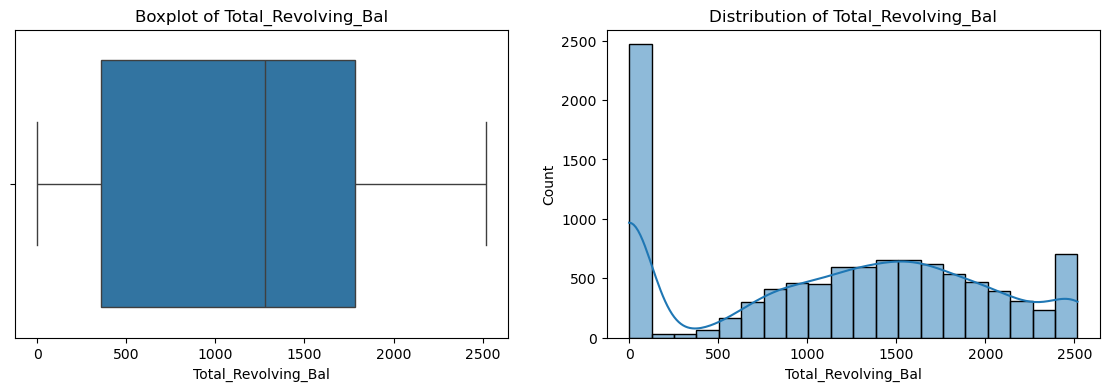

Num of outliers : 0
% of outliers : 0.0 %


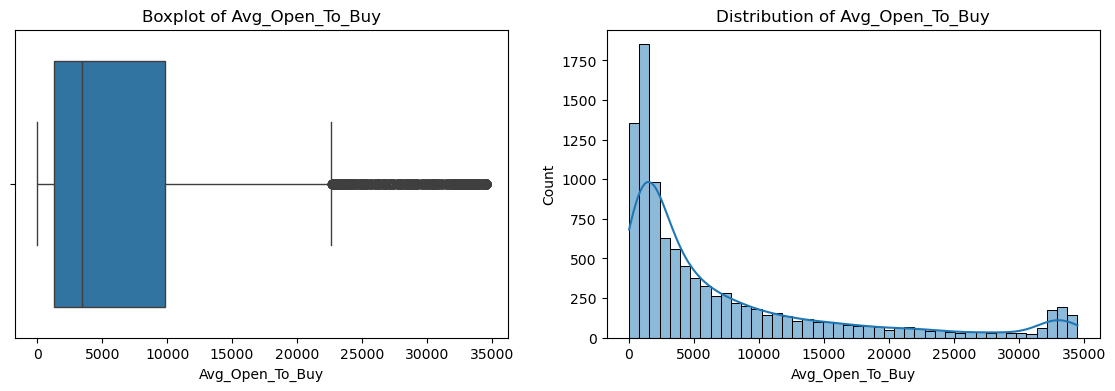

Num of outliers : 963
% of outliers : 9.509232744149305 %


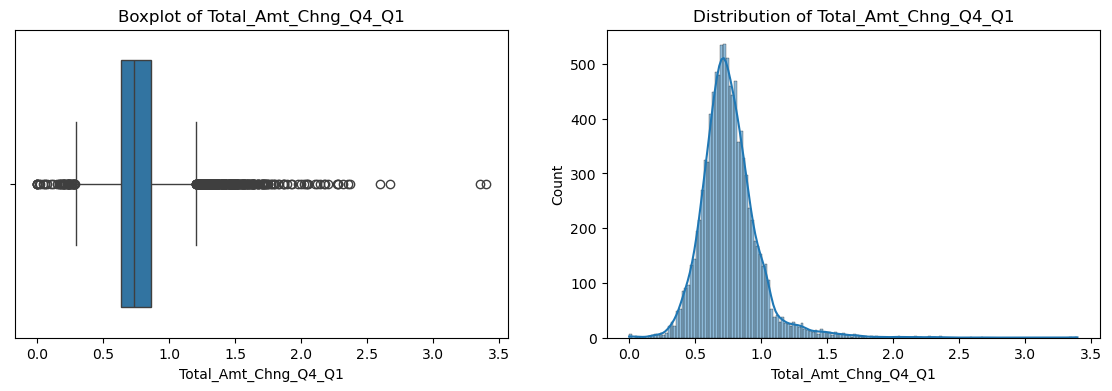

Num of outliers : 396
% of outliers : 3.9103386985286854 %


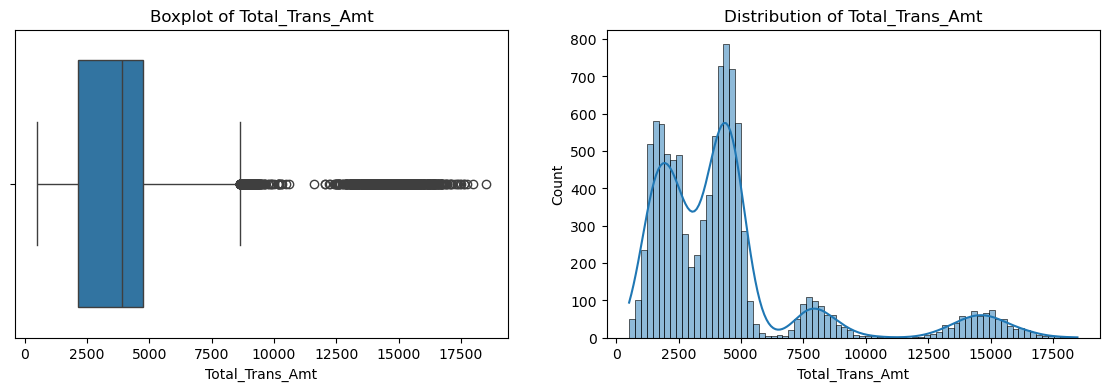

Num of outliers : 896
% of outliers : 8.847635035054804 %


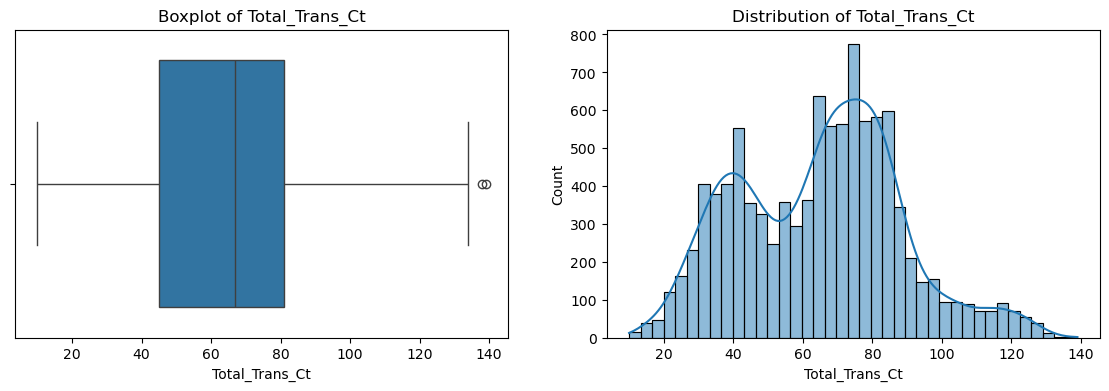

Num of outliers : 2
% of outliers : 0.019749185346104474 %


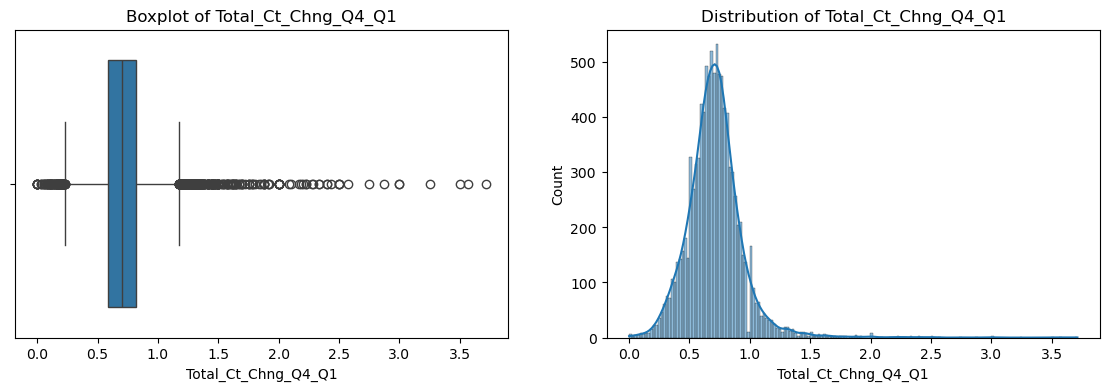

Num of outliers : 394
% of outliers : 3.890589513182581 %


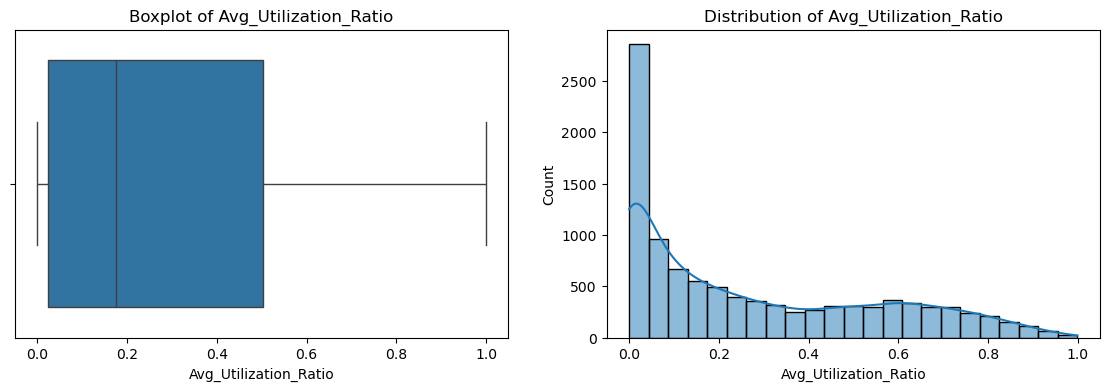

Num of outliers : 0
% of outliers : 0.0 %


In [33]:
# outliers 시각화
numeric_col = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in numeric_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # 1열: 상자 그림(Boxplot)
    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f'Boxplot of {col}')

    # 2열: 데이터 분포를 나타내는 히스토그램
    sns.histplot(df[col], kde=True, ax=axes[1])
    axes[1].set_title(f'Distribution of {col}')

    plt.show()
    print('Num of outliers :', numeric_iqr (df, col) )
    print('% of outliers :', numeric_iqr (df, col) / len(df) * 100, '%')

<AxesSubplot:>

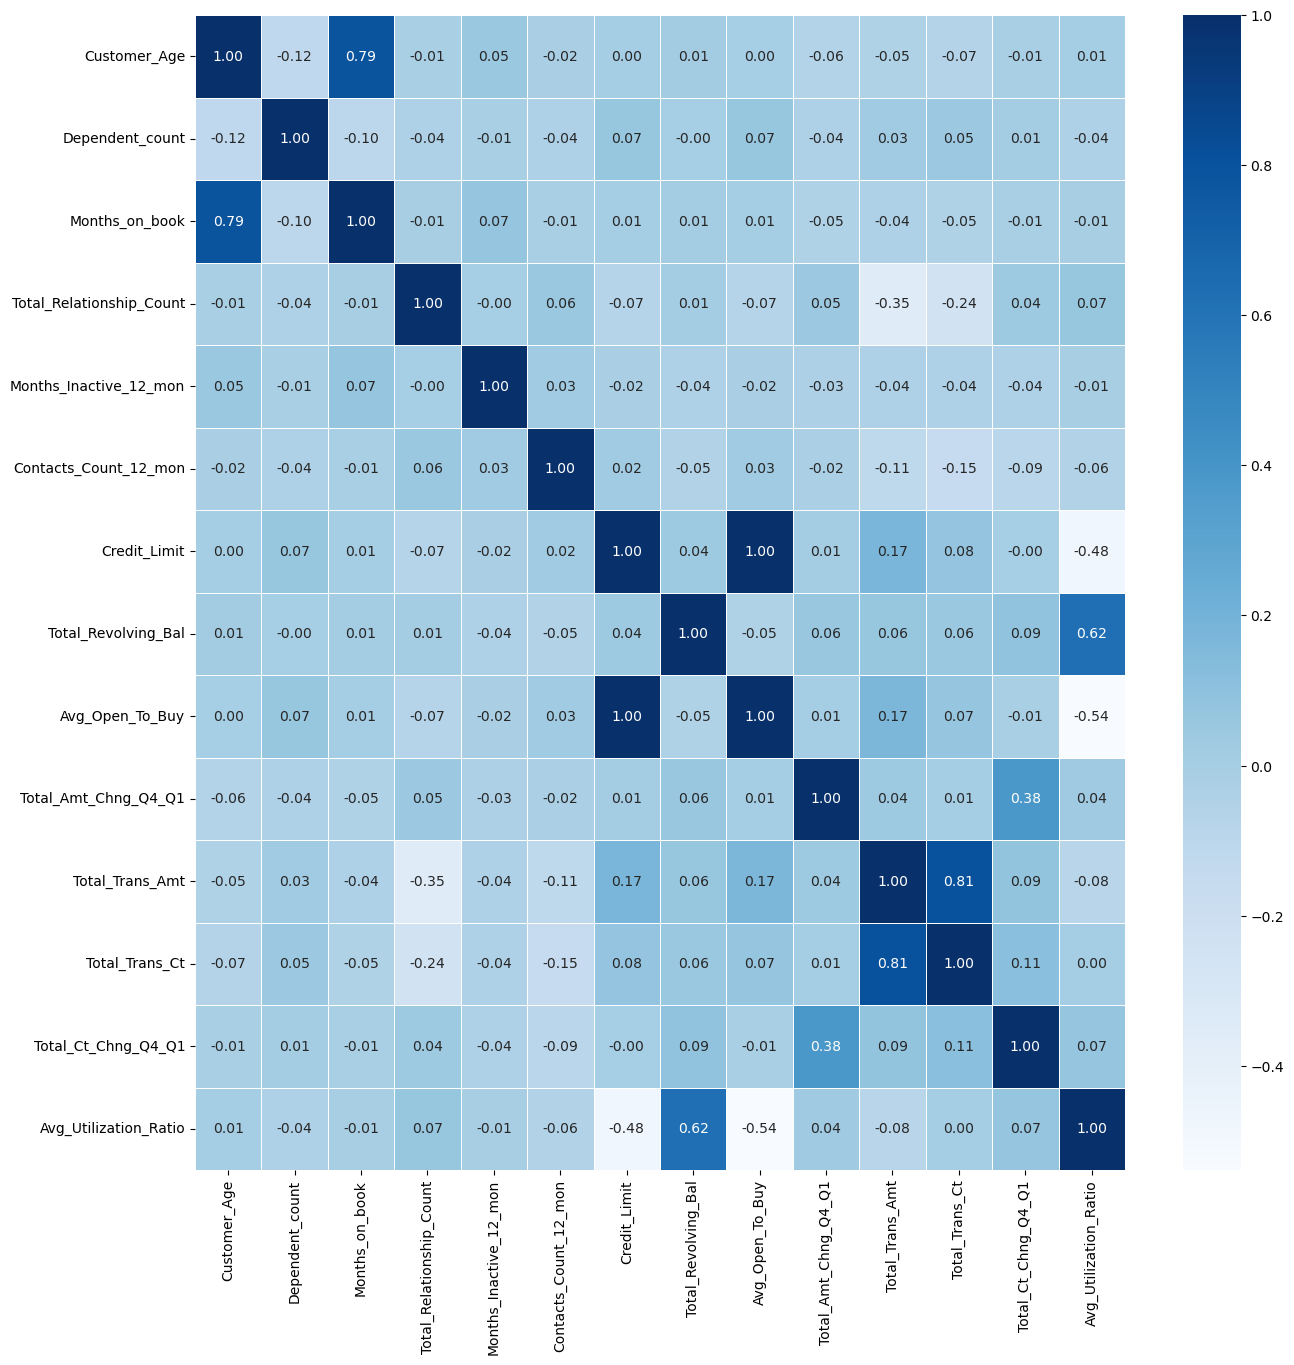

In [38]:
# 상관관계 
plt.figure(figsize=(15,15))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [79]:
# 상관관계 >= 0.8 인 컬럼 제거
df.drop('Avg_Open_To_Buy', axis = 1, inplace = True)
df.drop('Total_Trans_Ct', axis = 1, inplace = True)

In [73]:
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})

In [81]:
# 더미변수 
df = pd.get_dummies(df)

# gender 의 값은 2개이므로 더미변수화하면 상관계수 = 1 -> 제거 
df.drop('Gender_F', axis = 1, inplace = True)

## 2. Modeling

- 평가 척도 : log loss. 이는 분류 문제에서 모델의 성능을 평가하는 데 사용되는 손실 함수로, 낮을수록 모델의 성능이 좋음

### Train, Test split

In [82]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition_Flag', axis=1)  
y = df['Attrition_Flag']               
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

### Standardscaler

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

### Oversampling

In [87]:
# raw data와 오버샘플링한 데이터 두 가지를 이용하여 결과 비교
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over,y_train_over = smote.fit_resample(x_train_scaled,y_train)

print('SMOTE 적용 전 학습 데이터 세트: ', x_train_scaled.shape, y_train.shape)
print('SMOTE 적용 후 학습 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 :\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습 데이터 세트:  (8101, 34) (8101,)
SMOTE 적용 후 학습 데이터 세트:  (13602, 34) (13602,)
SMOTE 적용 후 레이블 값 분포 :
 0    6801
1    6801
Name: Attrition_Flag, dtype: int64


### 2.1 Soft Voting

In [125]:
def soft_voting(X_train, X_test, y_train, y_test) :
    dt = DecisionTreeClassifier(random_state=42)
    lr = LogisticRegression(random_state=42)

    model = VotingClassifier(estimators=[('dt', dt), ('lr', lr)],voting='soft')
    model.fit(X_train, y_train)
    
    params = model.get_params() #확인용
    proba = model.predict(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

### 2.2 Bagging

In [126]:
def bagging_clf(X_train, X_test, y_train, y_test) :
    svc = SVC(probability=True, random_state=42)

    model = BaggingClassifier(base_estimator = svc,  
                              bootstrap=True, 
                              n_jobs=-1)
    model.fit(X_train, y_train)
    
    params = model.get_params()
    proba = model.predict(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

### 2.3 RandomForest

In [127]:
def random_forest(X_train, X_test, y_train, y_test) :
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    params = model.get_params()
    proba = model.predict_proba(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

### 2.4 Xgboost

In [128]:
def xgboost(X_train, X_test, y_train, y_test) :
    
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    params = model.get_params()
    proba = model.predict_proba(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

### 2.5 Catboost

- catboost는 범주형 변수가 많은 데이터셋에 대해 성능이 우수한 모델로, 범주형 변수는 전처리 필요없이 그대로 model의 input으로 사용할 수 있다. 
- 이 예제에서는 편의상 범주형 변수가 전처리 된 데이터를 사용하는 것으로 한다.

In [129]:
def catboost(X_train, X_test, y_train, y_test) :
    
    model = CatBoostClassifier(random_state=42, silent = True)
    model.fit(X_train, y_train)
    
    params = model.get_params() 
    proba = model.predict_proba(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

### 2.6 LGBM

In [130]:
def lgbm(X_train, X_test, y_train, y_test) :
    
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    params = model.get_params()
    proba = model.predict_proba(X_test)
    log_score = log_loss(y_test, proba)
    
    return params, log_score

## 3. Results

In [145]:
model_name = ['soft_voting', 'bagging_clf', 'random_forest', 'xgboost', 'catboost', 'lgbm']

def show_results(X_train, X_test, y_train, y_test) :
    logloss = []
    parameters_dic = {}
    
    for model in model_name :
        model_function = globals()[model]
        params, log_loss = model_function(X_train, X_test, y_train, y_test)
    
        logloss.append(log_loss)
        parameters_dic[model_function] = params
        
    return parameters_dic, logloss

### 3.1 Raw data

In [146]:
params, logloss = show_results(x_train_scaled, x_test_scaled, y_train, y_test)
logloss 

[2.659479313635825,
 3.818714855460188,
 0.17888311492958162,
 0.12596822104116873,
 0.10424659488123408,
 0.11212498056626861]

### 3.2 Oversampling

In [147]:
over_params, over_logloss = show_results(X_train_over, x_test_scaled, y_train_over, y_test)
over_logloss 

[3.35846460722743,
 5.148496741757384,
 0.2052380595727954,
 0.12135673939661819,
 0.10852512786369001,
 0.1130072211136693]

### 3.3 Comparison 

In [148]:
results_df = pd.DataFrame({
    'Model Name': model_name,
    'Log Loss (Raw Data)': logloss,
    'Log Loss (Oversampled Data)': over_logloss
})

results_df

,Model Name,Log Loss (Raw Data),Log Loss (Oversampled Data)
0,soft_voting,2.659479,3.358465
1,bagging_clf,3.818715,5.148497
2,random_forest,0.178883,0.205238
3,xgboost,0.125968,0.121357
4,catboost,0.104247,0.108525
5,lgbm,0.112125,0.113007


## 4. Optuna

- 전체 결과 중 log loss 값이 가장 낮은 raw data에 대해 훈련한 catboost에 하이퍼파라미터 튜닝을 진행한다.
- 이때, 하이퍼파라미터를 자동으로 최적화해주는 프레임워크인 Optuna를 사용한다


In [120]:
!pip install optuna


     ------------------------------------ 413.4/413.4 kB 955.4 kB/s eta 0:00:00
     -------------------------------------- 233.4/233.4 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00


In [184]:
import optuna
from optuna.samplers import TPESampler

#x_train, X_valid, y_train, y_valid = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# optuna
def objective(trial):
    param = {
        "random_state":42,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3), 
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100), # higher value, more randomly
        "n_estimators":trial.suggest_int("n_estimators", 3, 70), # number of trees 
        "max_depth":trial.suggest_int("max_depth", 4, 16), # tree depth
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), # feature
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5), # l2 regularization term
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])} # how detect overfitting (val_loss increase or iterations)
        
    model = CatBoostClassifier(**param, silent = True)
    model.fit(x_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True, early_stopping_rounds=50)
    
    proba = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, proba)
    
    return log_score

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=100)

print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2024-02-12 00:47:53,007] A new study created in memory with name: cat_parameter_opt
[I 2024-02-12 00:47:54,304] Trial 0 finished with value: 0.4010319806901103 and parameters: {'learning_rate': 0.008468008575248327, 'bagging_temperature': 63.512210106407046, 'n_estimators': 52, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.4010319806901103.
[I 2024-02-12 00:47:54,442] Trial 1 finished with value: 0.28682461650314706 and parameters: {'learning_rate': 0.2526878207508456, 'bagging_temperature': 21.368329072358772, 'n_estimators': 17, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.28682461650314706.
[I 2024-02-12 00:47:59,122] Trial 2 finished with value: 

[I 2024-02-12 00:48:11,969] Trial 20 finished with value: 0.26511900261376237 and parameters: {'learning_rate': 0.10160424487631362, 'bagging_temperature': 0.09870680474904545, 'n_estimators': 41, 'max_depth': 10, 'random_strength': 41, 'colsample_bylevel': 0.6677030037130866, 'l2_leaf_reg': 1.4081794334335924e-05, 'min_child_samples': 26, 'max_bin': 240, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:48:15,003] Trial 21 finished with value: 0.16812688287453445 and parameters: {'learning_rate': 0.020914683612374755, 'bagging_temperature': 24.189716030678508, 'n_estimators': 53, 'max_depth': 12, 'random_strength': 1, 'colsample_bylevel': 0.9055342235071431, 'l2_leaf_reg': 4.55507808445248e-06, 'min_child_samples': 63, 'max_bin': 252, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:48:17,061] Trial 22 finished with value: 0.19977320520623426 and parameters: {'learning_rate': 0.013121481010947199, 'bagging_temp

[I 2024-02-12 00:49:28,028] Trial 40 finished with value: 0.3097440482632468 and parameters: {'learning_rate': 0.06865110962852843, 'bagging_temperature': 1.611732180309361, 'n_estimators': 28, 'max_depth': 15, 'random_strength': 63, 'colsample_bylevel': 0.8864507750254822, 'l2_leaf_reg': 2.3044001118099435e-06, 'min_child_samples': 89, 'max_bin': 260, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:49:32,235] Trial 41 finished with value: 0.14346320632106027 and parameters: {'learning_rate': 0.0198556439524817, 'bagging_temperature': 99.24953935935314, 'n_estimators': 51, 'max_depth': 12, 'random_strength': 0, 'colsample_bylevel': 0.9282331822228639, 'l2_leaf_reg': 5.669001489133378e-06, 'min_child_samples': 61, 'max_bin': 247, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:49:33,914] Trial 42 finished with value: 0.3173315243079517 and parameters: {'learning_rate': 0.014987380870120817, 'bagging_temperatur

[I 2024-02-12 00:50:56,582] Trial 60 finished with value: 0.3022405868983771 and parameters: {'learning_rate': 0.04169472988464818, 'bagging_temperature': 0.532121642421581, 'n_estimators': 51, 'max_depth': 7, 'random_strength': 86, 'colsample_bylevel': 0.7556967331149573, 'l2_leaf_reg': 5.68754555828758e-06, 'min_child_samples': 84, 'max_bin': 332, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:51:41,191] Trial 61 finished with value: 0.17646101529714373 and parameters: {'learning_rate': 0.03838298651708348, 'bagging_temperature': 57.1637916803484, 'n_estimators': 47, 'max_depth': 16, 'random_strength': 0, 'colsample_bylevel': 0.9053531324900489, 'l2_leaf_reg': 1.415108330953329e-05, 'min_child_samples': 66, 'max_bin': 232, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:52:04,704] Trial 62 finished with value: 0.20530551677714423 and parameters: {'learning_rate': 0.018776143053473755, 'bagging_temperature'

[I 2024-02-12 00:53:18,867] Trial 80 finished with value: 0.2594836725125417 and parameters: {'learning_rate': 0.04728091768259303, 'bagging_temperature': 2.799821835479151, 'n_estimators': 51, 'max_depth': 11, 'random_strength': 12, 'colsample_bylevel': 0.9286940145608874, 'l2_leaf_reg': 4.253555494453006e-06, 'min_child_samples': 78, 'max_bin': 267, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:53:25,806] Trial 81 finished with value: 0.14955840398646075 and parameters: {'learning_rate': 0.011354168241288267, 'bagging_temperature': 0.0340407722350563, 'n_estimators': 50, 'max_depth': 13, 'random_strength': 0, 'colsample_bylevel': 0.8646812030823379, 'l2_leaf_reg': 2.5816356025549203e-06, 'min_child_samples': 51, 'max_bin': 235, 'od_type': 'Iter'}. Best is trial 11 with value: 0.13579631248317858.
[I 2024-02-12 00:53:26,241] Trial 82 finished with value: 0.32282777840859145 and parameters: {'learning_rate': 0.011595770261195796, 'bagging_temper

Best Score: 0.13579631248317858
Best trial {'learning_rate': 0.04774158350062327, 'bagging_temperature': 3.2459285904913147, 'n_estimators': 69, 'max_depth': 7, 'random_strength': 1, 'colsample_bylevel': 0.8716448625177555, 'l2_leaf_reg': 1.1596122379501143e-05, 'min_child_samples': 5, 'max_bin': 204, 'od_type': 'Iter'}


In [185]:
best_params = study.best_params

model = CatBoostClassifier(**best_params, silent = True)
model.fit(x_train, y_train)

proba = model.predict_proba(x_test_scaled)
print("Log Loss : ", log_loss(y_test, proba))

Log Loss :  0.1609079586152705


In [186]:
# 변수 중요도 그래프
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

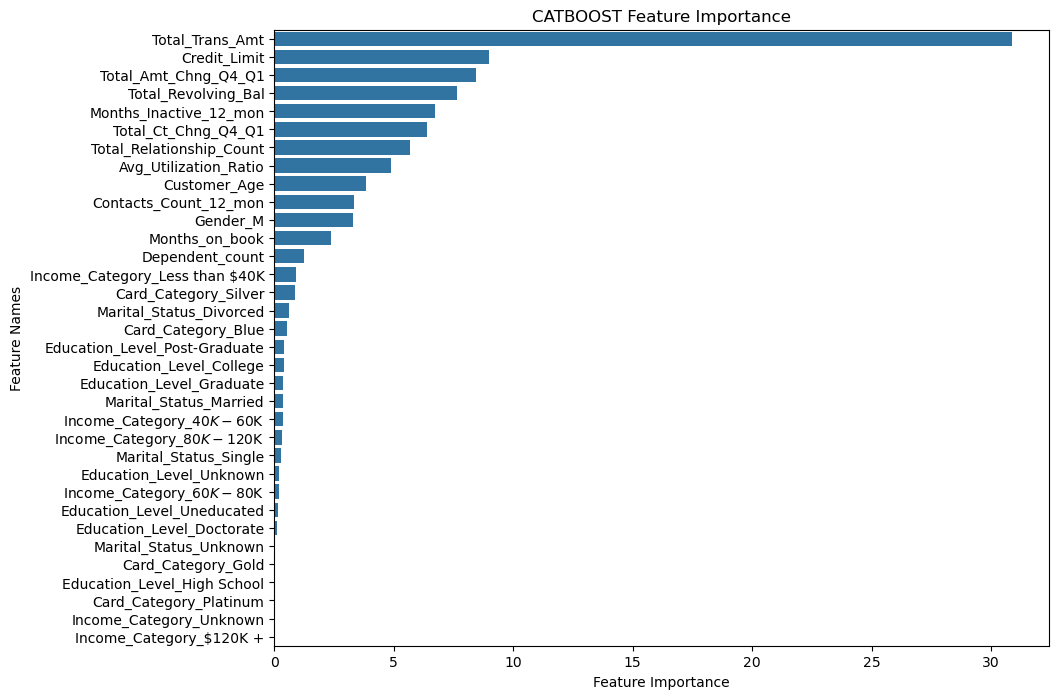

In [187]:
plot_feature_importance(model.get_feature_importance(),X_test.columns,'CATBOOST')